In [ ]:
import numpy as np
import os
import random
import shutil
import time
import warnings
from collections import defaultdict
from functools import reduce
import json
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models


from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/Courses/CS545_MLSP/CS545_MLSP_Project/Code/')
# from model import *
from modeldropout import *

Mounted at /content/drive


In [ ]:
# epochs: 20
training_params  = {
    "batch_size" : 32,
    "test_batch_size" : 64,
    "epochs" : 10,
    "start_epoch" : 1,
    "n_warmup_steps" : 1000,
    "log_interval" : 30
}
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu') #torch.device('cpu')

## DataLoader and AFF

In [ ]:
# AFF 

def local_att(x):
    mean = torch.mean(x)
    mean = torch.reshape(mean, [1])
    var = torch.var(x, unbiased = True)
    var = torch.reshape(var, [1])
    x = F.conv2d(x, torch.randn(1, 1, 2, 2), stride=1)
    x = F.batch_norm(x, running_mean=mean, running_var=var)
    x = F.relu(x, inplace=True)
    x = F.conv2d(x, torch.randn(1, 1, 2, 2), stride=1)
    mean = torch.mean(x)
    mean = torch.reshape(mean, [1])
    var = torch.var(x, unbiased = True)
    var = torch.reshape(var, [1])
    x = F.batch_norm(x, running_mean=mean, running_var=var)

    return x

def global_att(x):
    x = F.adaptive_avg_pool2d(x, 3)
    x = F.conv2d(x, torch.randn(1, 1, 2, 2), stride=1)
    mean = torch.mean(x)
    mean = torch.reshape(mean, [1])
    var = torch.var(x, unbiased = True)
    var = torch.reshape(var, [1])
    x = F.batch_norm(x, running_mean=mean, running_var=var)
    x = F.relu(x, inplace=True)
    x = F.conv2d(x, torch.randn(1, 1, 2, 2), stride=1)
    mean = torch.mean(x)
    mean = torch.reshape(mean, [1])
    var = torch.var(x, unbiased = True)
    var = torch.reshape(var, [1])
    x = F.batch_norm(x, running_mean=mean, running_var=var)

    return x

def aff(x, y):
    xa = x + y
    xl = local_att(xa)
    xg = global_att(xa)
    del xa
    gc.collect()

    xlg = xl + xg
    del xl, xg
    gc.collect()
    
    # wei = torch.sigmoid(xlg)
    padded_wei = F.pad(torch.sigmoid(xlg),(1,1,1,1))
    xo = 2 * x * padded_wei + 2 * y * (1 - padded_wei)

    return xo

def aff_combined(x, y):
    xl = x + y
    
    # Local attention
    # xl = local_att(xa)
    mean = torch.mean(xl)
    mean = torch.reshape(mean, [1])
    var = torch.var(xl, unbiased = True)
    var = torch.reshape(var, [1])
    xl = F.conv2d(xl, torch.randn(1, 1, 2, 2), stride=1)
    xl = F.batch_norm(xl, running_mean=mean, running_var=var)

    del mean, var
    gc.collect()

    xl = F.relu(xl, inplace=True)
    xl = F.conv2d(xl, torch.randn(1, 1, 2, 2), stride=1)
    mean = torch.mean(xl)
    mean = torch.reshape(mean, [1])
    var = torch.var(xl, unbiased = True)
    var = torch.reshape(var, [1])
    xl = F.batch_norm(xl, running_mean=mean, running_var=var)

    del mean, var
    gc.collect()

    # global attention
    xg = x + y
    # xg = global_att(xa)

    xg = F.adaptive_avg_pool2d(xg, 3)
    xg = F.conv2d(xg, torch.randn(1, 1, 2, 2), stride=1)
    mean = torch.mean(xg)
    mean = torch.reshape(mean, [1])
    var = torch.var(xg, unbiased = True)
    var = torch.reshape(var, [1])
    xg = F.batch_norm(xg, running_mean=mean, running_var=var)

    del mean, var
    gc.collect()

    xg = F.relu(xg, inplace=True)
    xg = F.conv2d(xg, torch.randn(1, 1, 2, 2), stride=1)
    mean = torch.mean(xg)
    mean = torch.reshape(mean, [1])
    var = torch.var(xg, unbiased = True)
    var = torch.reshape(var, [1])
    xg = F.batch_norm(xg, running_mean=mean, running_var=var)
    
    del mean, var
    gc.collect()

    xlg = xl + xg
    del xl, xg
    gc.collect()
    
    # wei = torch.sigmoid(xlg)
    padded_wei = F.pad(torch.sigmoid(xlg),(1,1,1,1))

    del xlg
    gc.collect()

    xo = 2 * x * padded_wei + 2 * y * (1 - padded_wei)

    return xo

In [ ]:
class AudioFeatureDataset(Dataset):
    def __init__(self, filepath, sampleCount = 2000):

        #------------------------------------------------------------------------------------------------------------------------------------------------#
        # MFCC data
        #------------------------------------------------------------------------------------------------------------------------------------------------#
        X = np.load(filepath + 'real/mfcc.npy')
        realRandomIndexSubset = np.random.choice(X.shape[0], sampleCount, replace=False)
        realMfccData = torch.Tensor(X[realRandomIndexSubset])
        del X
        gc.collect()

        X = np.load(filepath + 'fake/mfcc.npy')
        fakeRandomIndexSubset = np.random.choice(X.shape[0], sampleCount, replace=False)
        fakeMfccData = torch.Tensor(X[fakeRandomIndexSubset])
        del X 
        gc.collect()

        self.labels = np.concatenate((np.zeros(fakeMfccData.shape[0]), np.ones(realMfccData.shape[0]))).astype(np.int64)  # 0=fake, 1=real

        paddedMfccData = torch.reshape(F.pad(torch.cat((fakeMfccData, realMfccData), axis = 0)\
                                             , (0,0,58,58), mode='constant', value=0),\
                                        (-1,1,136,44))
        del fakeMfccData, realMfccData
        gc.collect()
        print('MFCC:', paddedMfccData.shape)
        #------------------------------------------------------------------------------------------------------------------------------------------------#
        # LFCC data
        #------------------------------------------------------------------------------------------------------------------------------------------------#
        X = np.load(filepath + 'real/lfcc.npy')
        realLfccData = torch.Tensor(X[realRandomIndexSubset])
        del X
        gc.collect()

        X = np.load(filepath + 'fake/lfcc.npy')
        fakeLfccData = torch.Tensor(X[fakeRandomIndexSubset])
        del X
        gc.collect()

        paddedLfccData = torch.reshape(F.pad(torch.cat((fakeLfccData, realLfccData), axis = 0)\
                                             , (15,16), mode='constant', value=0),\
                                        (-1,1,136,44))
        del fakeLfccData, realLfccData
        gc.collect()

        print('LFCC:', paddedLfccData.shape)

        #--------------------------------------------------------------------------------------------------------------------------------------------------#

        paddedMfccData = F.conv2d(paddedMfccData, torch.randn(1,1,2,2), stride=1)
        paddedLfccData = F.conv2d(paddedLfccData, torch.randn(1,1,2,2), stride=1)

        self.fusedFeatures = aff(paddedMfccData, paddedLfccData) 
        print('Fused features shape: ', self.fusedFeatures.shape)

        del paddedMfccData, paddedLfccData
        gc.collect()

    def __len__(self):
        return len(self.fusedFeatures)

    def __getitem__(self, idx):
        return self.fusedFeatures[idx], self.labels[idx]

## Loading Data

In [ ]:
kwargs =  {'num_workers': 1, 'pin_memory': True} if device == torch.device('cuda') else {}

print('\nTraining Data:')
trainDataset = AudioFeatureDataset('./features/for/training/', 20000)
# trainDataset, testDataset = torch.utils.data.random_split(trainDataset, [32000, 8000])
print(len(trainDataset), len(testDataset))
trainLoader = DataLoader(trainDataset, batch_size=training_params['batch_size'], shuffle = True, **kwargs)
del trainDataset

print('\nTesting Data:')
testDataset = AudioFeatureDataset('./features/for/testing/', 4000)
testLoader = DataLoader(testDataset, batch_size=training_params['test_batch_size'], shuffle = True, **kwargs)
del testDataset


Training Data:
MFCC: torch.Size([40000, 1, 136, 44])
Fused features shape:  torch.Size([40000, 1, 136, 44])
32000 8000

Testing Data:


## Data Augmentation

In [ ]:
import math

def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape

    F = math.ceil(n_mels * max_mask_pct)
    T = math.ceil(n_steps * max_mask_pct)

    # Create frequency masks
    fill = spec.mean()
    for i in range(0, n_freq_masks):
      f = random.randint(0, F)
      f0 = random.randint(0, n_mels-f)
      spec[0][f0:f0+f] = fill
    
    # Create time masks
    for i in range(0, n_time_masks):
      t = random.randint(0, T)
      t0 = random.randint(0, n_steps-t)
      spec[0][:,t0:t0+t] = fill
    return spec

### Masked MFCC generation

In [ ]:
paths = ['./features/for/testing/fake/', './features/for/training/fake/', './features/for/validation/fake/', './features/for/testing/real/', './features/for/training/real/', './features/for/validation/real/']

for path in paths:
  # load mfcc.npy
  mfccs = np.load(path + 'mfcc.npy')
  print(mfccs.shape)
  # for every entry in mfcc.npy, augment, reshape and add back to a new list
  data = []
  for mfcc in mfccs:
    mfcc_aug = spectro_augment(mfcc.reshape(1,20,44), max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
    data.append(mfcc_aug.reshape(20, 44))

  data = np.array(data)
  print(data.shape)
  np.save(path +'mfcc_masked.npy', data)
#save the new list

(4013, 20, 44)
(4013, 20, 44)
(45814, 20, 44)
(45814, 20, 44)
(9192, 20, 44)
(9192, 20, 44)
(5281, 20, 44)
(5281, 20, 44)
(104954, 20, 44)
(104954, 20, 44)
(20917, 20, 44)
(20917, 20, 44)


### Masked MFCC Image

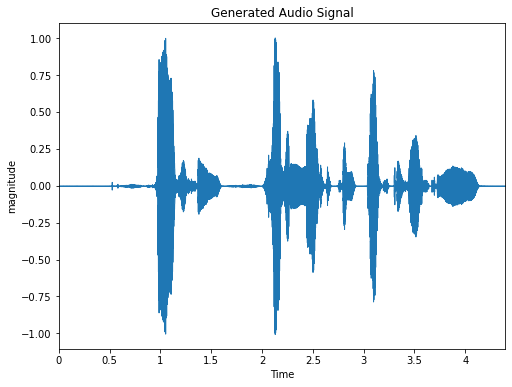

In [ ]:
import librosa.display
import matplotlib.pyplot as plt

fig, ax = plt.subplots() 
fig.set_size_inches(8, 6)

# Signal
ax.set(title='Generated Audio Signal', xlabel = 'time', ylabel='magnitude')
y, sr = librosa.load('./data/test/real/la/LA_R2.flac', mono=False, duration=10)
librosa.display.waveplot(y, sr=sr, ax=ax)
fig.savefig('./Report_content/real_audio_signal.png')

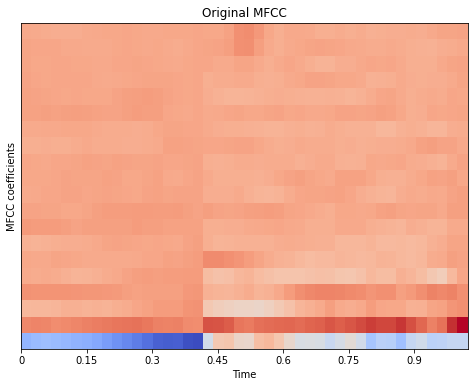

In [ ]:
# MFCC
fig, ax = plt.subplots() 
fig.set_size_inches(8, 6)

ax.set(title='Original MFCC', xlabel = 'time', ylabel='MFCC coefficients')
mfccs = np.load('./data/test/real/features_real/la/mfcc.npy')
librosa.display.specshow(mfccs[1], x_axis='time', ax = ax)
fig.gca().set_xlabel("Time")
fig.gca().set_ylabel("MFCC coefficients")

fig.savefig('./Report_content/real_audio_MFCC.png')

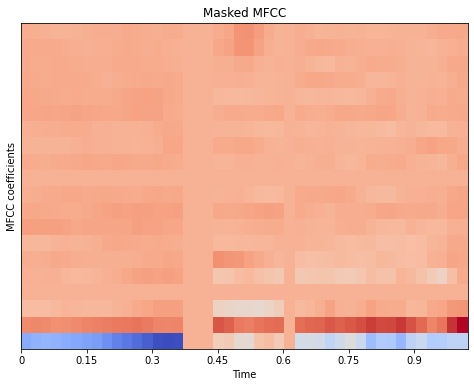

In [ ]:
# Masked MFCC
fig, ax = plt.subplots() 
fig.set_size_inches(8, 6)

ax.set(title='Masked MFCC', xlabel = 'time', ylabel='MFCC coefficients')
mfcc_aug = spectro_augment(mfccs[1].reshape(1,20,44), max_mask_pct=0.07, n_freq_masks=4, n_time_masks=2)
librosa.display.specshow(mfcc_aug.reshape(20, 44), x_axis = 'time', ax = ax)
fig.gca().set_xlabel("Time")
fig.gca().set_ylabel("MFCC coefficients")

fig.savefig('./Report_content/real_audio_Masked_MFCC.png')

### Masked LFCC Images

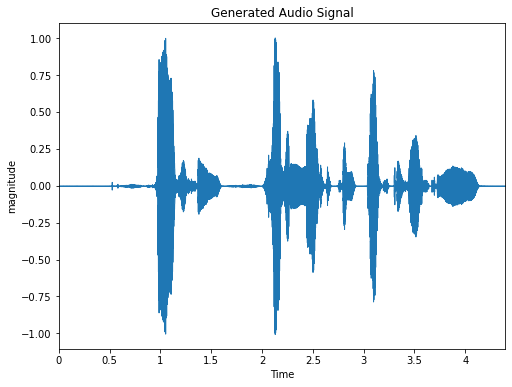

In [ ]:
import librosa.display
import matplotlib.pyplot as plt

fig, ax = plt.subplots() 
fig.set_size_inches(8, 6)

# Signal
ax.set(title='Generated Audio Signal', xlabel = 'time', ylabel='magnitude')
y, sr = librosa.load('./data/test/real/la/LA_R2.flac', mono=False, duration=10)
librosa.display.waveplot(y, sr=sr, ax=ax)
fig.savefig('./Report_content/real_audio_signal.png')

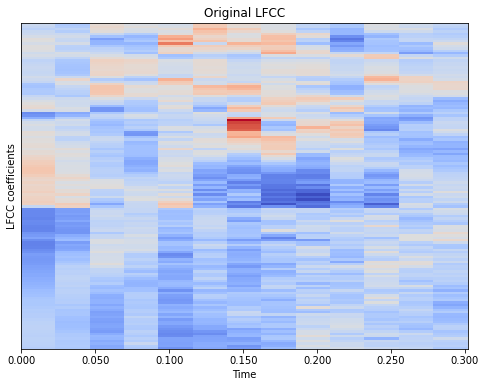

In [ ]:
# LFCC
fig, ax = plt.subplots() 
fig.set_size_inches(8, 6)

ax.set(title='Original LFCC', xlabel = 'time', ylabel='LFCC coefficients')
lfccs = np.load('./data/test/real/features_real/la/lfcc.npy')
librosa.display.specshow(lfccs[1], x_axis='time', ax = ax)
fig.gca().set_xlabel("Time")
fig.gca().set_ylabel("LFCC coefficients")

fig.savefig('./Report_content/real_audio_LFCC.png')

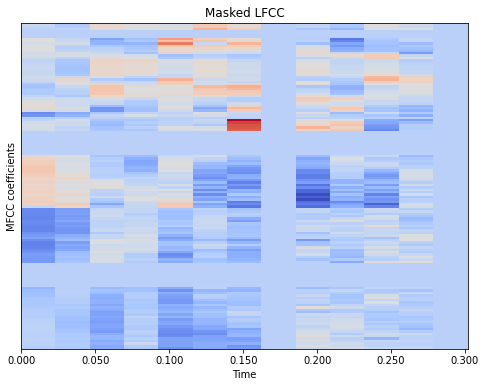

In [ ]:
# Masked MFCC
fig, ax = plt.subplots() 
fig.set_size_inches(8, 6)

ax.set(title='Masked LFCC', xlabel = 'time', ylabel='LFCC coefficients')
lfcc_aug = spectro_augment(lfccs[1].reshape(1,136,13), max_mask_pct=0.07, n_freq_masks=4, n_time_masks=2)
librosa.display.specshow(lfcc_aug.reshape(136, 13), x_axis='time', ax = ax)
fig.gca().set_xlabel("Time")
fig.gca().set_ylabel("MFCC coefficients")

fig.savefig('./Report_content/real_audio_Masked_LFCC.png')


### Masked LFCC generation

In [ ]:
paths = ['./features/for/testing/fake/', './features/for/training/fake/', './features/for/validation/fake/', './features/for/testing/real/', './features/for/training/real/', './features/for/validation/real/']

for path in paths:
  # load lfcc.npy
  lfccs = np.load(path + 'lfcc.npy')
  print(lfccs.shape)
  # for every entry in lfcc.npy, augment, reshape and add back to a new list
  data = []
  for lfcc in lfccs:
    lfcc_aug = spectro_augment(lfcc.reshape(1,136,13), max_mask_pct=0.07, n_freq_masks=4, n_time_masks=2)
    data.append(lfcc_aug.reshape(136, 13))

  data = np.array(data)
  print(data.shape)
  np.save(path +'lfcc_masked.npy', data)
#save the new list

(4013, 136, 13)
(4013, 136, 13)
(45814, 136, 13)
(45814, 136, 13)
(9192, 136, 13)
(9192, 136, 13)
(5281, 136, 13)
(5281, 136, 13)
(104954, 136, 13)
(104954, 136, 13)
(20917, 136, 13)
(20917, 136, 13)


## Training and Evaluation

In [ ]:
'''
Helps save the best model during testing
'''
def save_checkpoint(state, is_best, path, filename='checkpoint.pth.tar'):
    torch.save(state, path + '/' + filename)
    if is_best:
        print("===> save to checkpoint at {}\n".format(path + '/' + 'model_best.pth.tar'))
        shutil.copyfile(path + '/' + filename, path + '/' + 'model_best.pth.tar')

'''
Helps with maintaining the current and running average value for various metrics
'''
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / (self.count+1e-10)

'''
Used to compute the accuracy for top k values
'''
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

'''
This is a class used for updating the learning rate
'''
class ScheduledOptim(object):

    def __init__(self, optimizer, n_warmup_steps):
        self.optimizer = optimizer
        self.d_model = 64
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.delta = 1

    def step(self):
        self.optimizer.step()

    def zero_grad(self):
        self.optimizer.zero_grad()

    def increase_delta(self):
        self.delta *= 2

    def update_learning_rate(self):
        self.n_current_steps += self.delta
        new_lr = np.power(self.d_model, -0.5) * np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = new_lr
        return new_lr

    def state_dict(self):
        ret = {
            'd_model': self.d_model,
            'n_warmup_steps': self.n_warmup_steps,
            'n_current_steps': self.n_current_steps,
            'delta': self.delta,
        }
        ret['optimizer'] = self.optimizer.state_dict()
        return ret

    def load_state_dict(self, state_dict):
        self.d_model = state_dict['d_model']
        self.n_warmup_steps = state_dict['n_warmup_steps']
        self.n_current_steps = state_dict['n_current_steps']
        self.delta = state_dict['delta']
        self.optimizer.load_state_dict(state_dict['optimizer'])

In [ ]:
def train(train_loader, model, optim, epoch, device, log_interval):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()
 
    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        # Create vaiables
        input  = input.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True).view((-1,))

        # compute output
        output = model(input)

        # loss 
        loss = F.nll_loss(output, target)

        # measure accuracy and record loss
        acc1, = accuracy(output, target, topk=(1, ))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0], input.size(0))

        # compute gradient and do SGD step
        optim.zero_grad()
        loss.backward(retain_graph=True)
        optim.step()
        lr = optim.update_learning_rate()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % log_interval == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'LR {lr:.6f}\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Acc@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                   epoch, i, len(train_loader), batch_time=batch_time,
                   data_time=data_time, lr=lr, loss=losses, top1=top1))

    return top1.val, top1.avg # returning the last accuracy and average accuracy for a given epoch

In [ ]:
def validate(val_loader, model, device, log_interval):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # evaluation mode
    model.eval()
    utt2scores = defaultdict(list)

    predictions, targets = [], []
    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            input  = input.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True).view((-1,))
            targets.extend([t.item() for t in target.to(torch.device('cpu'))])

            # compute output
            output = model(input)

            # calculating y_predicted
            pred = output.argmax(1)
            predictions.extend([p.item() for p in pred.to(torch.device('cpu'))])
        
            # loss 
            loss = F.nll_loss(output, target)

            # measure accuracy and record loss
            acc1, = accuracy(output, target, topk=(1, ))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0], input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % log_interval == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Acc@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                       i, len(val_loader), batch_time=batch_time, loss=losses,
                       top1=top1))

    print('===> Acc@1 {top1.avg:.3f}\n'.format(top1=top1))

    return top1.avg, predictions, targets

In [ ]:
def main(model, training_params, device):
    best_acc1 = 0
    batch_size = training_params['batch_size']
    test_batch_size = training_params['test_batch_size']
    epochs = training_params['epochs']
    start_epoch = training_params['start_epoch']
    n_warmup_steps = training_params['n_warmup_steps']
    log_interval = training_params['log_interval']
    
    # create model 
    num_model_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('===> Model total parameter: {}'.format(num_model_params))
    
    
    
    # define loss function (criterion) and optimizer
    optim = ScheduledOptim(
            torch.optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()),
            betas=(0.9, 0.98), eps=1e-09, weight_decay=1e-4, lr=3e-4, amsgrad=True),
        training_params['n_warmup_steps'])


    # data loader functionality here
    
    kwargs = {'num_workers': 2, 'pin_memory': True} if device == torch.device('cuda') else {}

    train_loader = trainLoader 
    val_loader = testLoader

    best_epoch = 0
    early_stopping, max_patience = 0, 100 # for early stopping
    os.makedirs("model_snapshots/" + str(run_id), exist_ok=True) 

    # list for storing the accuracy values for each epoch
    trainAccuracyVsEpoch = []
    testAccuracyVsEpoch = []

    # best predictions and targets
    best_predictions, best_targets = [], []

    for epoch in range(start_epoch, start_epoch+epochs):
        # training
        last_accuracy, average_accuracy = train(train_loader, model, optim, epoch, device, log_interval)
        trainAccuracyVsEpoch.append((last_accuracy, average_accuracy))
        # testing
        acc1, predictions, targets = validate(val_loader, model, device, log_interval)    
        testAccuracyVsEpoch.append(acc1)

        is_best = acc1 > best_acc1
        best_acc1 = max(acc1, best_acc1)
        
        print('Predictions: ', predictions)
        print('Targets: ', targets)

        # adjust learning rate + early stopping 
        if is_best:
            early_stopping = 0
            best_epoch = epoch + 1
            best_predictions, best_targets = predictions, targets
        else:
            early_stopping += 1
            if epoch - best_epoch > 2:
                optim.increase_delta()
                best_epoch = epoch + 1
        if early_stopping == max_patience:
            break
        
        # save model
        save_checkpoint({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'best_acc1': best_acc1,
            'optimizer' : optim.state_dict(),
            }, is_best,  "model_snapshots/" + str(run_id), str(epoch) + ('_%.3f'%acc1) + ".pth.tar")

    return trainAccuracyVsEpoch, testAccuracyVsEpoch, best_predictions, best_targets


In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(0)
random.seed(0)
run_id = 20
# pass whole data - output of feature fusion
data = []

model = se_resnet50(2,True).to(torch.device("cuda:0"))
trainAccuracyVsEpoch, testAccuracyVsEpoch, targets, predictions = main(model, training_params, device)

Using Kaiming Initialization.
===> Model total parameter: 1092594
Epoch: [1][0/1000]	Time 0.449 (0.449)	Data 0.090 (0.090)	LR 0.000004	Loss 0.6776 (0.6776)	Acc@1 53.125 (53.125)
Epoch: [1][30/1000]	Time 0.089 (0.104)	Data 0.000 (0.003)	LR 0.000123	Loss 0.7086 (0.7166)	Acc@1 56.250 (49.294)
Epoch: [1][60/1000]	Time 0.087 (0.097)	Data 0.000 (0.002)	LR 0.000241	Loss 0.6633 (0.7070)	Acc@1 46.875 (50.820)
Epoch: [1][90/1000]	Time 0.088 (0.095)	Data 0.000 (0.001)	LR 0.000360	Loss 0.6996 (0.7020)	Acc@1 46.875 (51.820)
Epoch: [1][120/1000]	Time 0.087 (0.093)	Data 0.000 (0.001)	LR 0.000478	Loss 0.6935 (0.7007)	Acc@1 53.125 (52.118)
Epoch: [1][150/1000]	Time 0.085 (0.092)	Data 0.000 (0.001)	LR 0.000597	Loss 0.7123 (0.6991)	Acc@1 46.875 (52.856)
Epoch: [1][180/1000]	Time 0.088 (0.092)	Data 0.000 (0.001)	LR 0.000715	Loss 0.7854 (0.6967)	Acc@1 43.750 (53.867)
Epoch: [1][210/1000]	Time 0.089 (0.091)	Data 0.000 (0.001)	LR 0.000834	Loss 0.8441 (0.6963)	Acc@1 46.875 (54.325)
Epoch: [1][240/1000]	Time 0

0.5 0.5 [0. 1.] [0. 1.] [0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

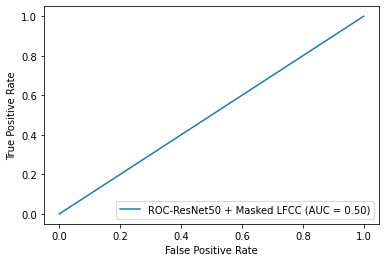

In [ ]:
# saving the ROC curve
import numpy as np
import sklearn.metrics 
import matplotlib.pyplot as plt

def calc_eer(label, pred, positive_label=1):

    fpr, tpr, threshold = sklearn.metrics.roc_curve(label, pred, pos_label=positive_label)
    fnr = 1 - tpr

    eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]

    
    eer_1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    eer_2 = fnr[np.nanargmin(np.absolute((fnr - fpr)))]

    eer = (eer_1 + eer_2) / 2

    auc_score = sklearn.metrics.auc(fpr, tpr)
    return eer, auc_score, fpr, tpr


model_name = 'ROC-ResNet50 + Masked LFCC'
eer, auc_score, fpr, tpr = calc_eer(targets, predictions, positive_label=1)
print(eer, auc_score, fpr, tpr, predictions, targets)

display = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score,estimator_name=model_name)
display.plot()
plt.savefig('./Report_content/' + model_name + '.png')

plt.show()

In [ ]:
 print('Test accuracy:', [a.cpu().numpy() for a in testAccuracyVsEpoch])
print('Train accuracy tuples (last_acc_of_epoch, avg_acc_of_epoch)', [(a.cpu().numpy(), b.cpu().numpy()) for a,b in trainAccuracyVsEpoch])

Test accuracy: [array(50.050003, dtype=float32), array(50.062504, dtype=float32), array(52.437504, dtype=float32), array(57.15, dtype=float32), array(61.500004, dtype=float32), array(56.862503, dtype=float32), array(66.3625, dtype=float32), array(69., dtype=float32), array(65.3125, dtype=float32), array(63.037502, dtype=float32)]
Train accuracy tuples (last_acc_of_epoch, avg_acc_of_epoch) [(array(78.125, dtype=float32), array(67.47188, dtype=float32)), (array(78.125, dtype=float32), array(82.00001, dtype=float32)), (array(90.625, dtype=float32), array(85.443756, dtype=float32)), (array(81.25, dtype=float32), array(86.94688, dtype=float32)), (array(87.5, dtype=float32), array(88.43751, dtype=float32)), (array(78.125, dtype=float32), array(89.06251, dtype=float32)), (array(100., dtype=float32), array(89.93438, dtype=float32)), (array(93.75, dtype=float32), array(90.012505, dtype=float32)), (array(87.5, dtype=float32), array(90.55625, dtype=float32)), (array(87.5, dtype=float32), array(90

In [ ]:
import matplotlib.pyplot as plt

def linePlot(Y):
    fig = plt.figure()
    ax = plt.axes()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Train Accuracies')
    
    ax.plot([i for i in range(1, len(Y)+1)], Y)

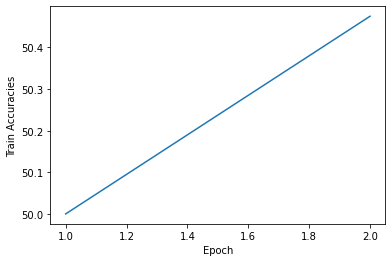

In [ ]:
linePlot(testAccuracyVsEpoch) #, testAccuracyVsEpoch

In [ ]:
linePlot([y for x,y in trainAccuracyVsEpoch])

## Visualization

In [ ]:
import matplotlib.pyplot as plt

### Train accuracies vs Epoch

In [ ]:
run3 = [( (87.5 ),  (68.49063 )), ( (84.375 ),  (82.11875 )), ( (93.75 ),  (84.47813 )), ( (71.875 ),  (86.87188 )), ( (84.375 ),  (87.75001 )), ( (84.375 ),  (88.96563 )), ( (93.75 ),  (89.425 )), ( (93.75 ),  (89.925 )), ( (96.875 ),  (90.00313 )), ( (81.25 ),  (90.53438 ))]
run4 = [( (84.375 ),  (64.80313 )), ( (93.75 ),  (78.36563 )), ( (78.125 ),  (82.76563 )), ( (84.375 ),  (84.88438 )), ( (87.5 ),  (85.61875 )), ( (84.375 ),  (86.50001 )), ( (96.875 ),  (87.32813 )), ( (96.875 ),  (87.43751 )), ( (90.625 ),  (87.78126 )), ( (87.5 ),  (88.262505 ))]
run5 =  [( (81.25 ),  (62.487503 )), ( (75. ),  (75.76875 )), ( (87.5 ),  (78.796875 )), ( (87.5 ),  (80.575005 )), ( (90.625 ),  (81.668755 )), ( (81.25 ),  (82.70938 )), ( (90.625 ),  (83.4875 )), ( (81.25 ),  (83.60938 )), ( (87.5 ),  (84.106255 )), ( (75. ),  (84.57188 ))]
run6 = [( (75. ),  (61.956253 )), ( (62.5 ),  (73.76875 )), ( (71.875 ),  (79.01875 )), ( (78.125 ),  (80.90313 )), ( (78.125 ),  (81.637505 )), ( (68.75 ),  (82.31563 )), ( (84.375 ),  (82.86875 )), ( (93.75 ),  (83.725006 )), ( (81.25 ),  (83.68125 )), ( (78.125 ),  (84.10313 ))]
run7 = [( (75. ),  (65.32188 )), ( (78.125 ),  (77.60313 )), ( (84.375 ),  (81.543755 )), ( (78.125 ),  (83.90626 )), ( (78.125 ),  (85.47813 )), ( (87.5 ),  (86.54063 )), ( (90.625 ),  (86.99375 )), ( (87.5 ),  (88.012505 )), ( (87.5 ),  (88.3 )), ( (87.5 ),  (88.918755 ))]
run8 =  [( (56.25 ),  (54.662502 )), ( (65.625 ),  (60.175003 )), ( (81.25 ),  (71.725006 )), ( (84.375 ),  (76.44688 )), ( (65.625 ),  (78.74375 )), ( (81.25 ),  (79.97813 )), ( (87.5 ),  (80.95625 )), ( (90.625 ),  (81.71876 )), ( (84.375 ),  (82.48438 )), ( (90.625 ),  (83.23438 ))]
run9 =  [( (81.25 ),  (77.421875 )), ( (78.125 ),  (90.04688 )), ( (81.25 ),  (92.425 )), ( (90.625 ),  (93.72188 )), ( (87.5 ),  (94.62501 )), ( (93.75 ),  (95.11563 )), ( (93.75 ),  (95.543755 )), ( (100. ),  (95.89375 )), ( (93.75 ),  (96.19063 )), ( (100. ),  (96.43125 )), ( (96.875 ),  (96.65938 )), ( (100. ),  (96.918755 )), ( (96.875 ),  (97.07188 )), ( (96.875 ),  (97.2125 )), ( (100. ),  (97.44688 ))]
run10 = [( (78.125 ),  (64.74375 )), ( (78.125 ),  (81.97813 )), ( (84.375 ),  (86.606255 )), ( (78.125 ),  (87.9625 )), ( (87.5 ),  (89.025 )), ( (84.375 ),  (90.106255 )), ( (93.75 ),  (90.80938 )), ( (100. ),  (91.63438 )), ( (84.375 ),  (91.975006 )), ( (90.625 ),  (92.0875 )), ( (93.75 ),  (92.77188 )), ( (96.875 ),  (92.76563 )), ( (87.5 ),  (93.162506 )), ( (90.625 ),  (93.325005 )), ( (93.75 ),  (93.54063 ))]

In [ ]:
run3 = [avg for (last, avg) in run3]
run4 = [avg for (last, avg) in run4]
run5 = [avg for (last, avg) in run5]
run6 = [avg for (last, avg) in run6]
run7 = [avg for (last, avg) in run7]
run8 = [avg for (last, avg) in run8]
run9 = [avg for (last, avg) in run9]
run10 = [avg for (last, avg) in run10]


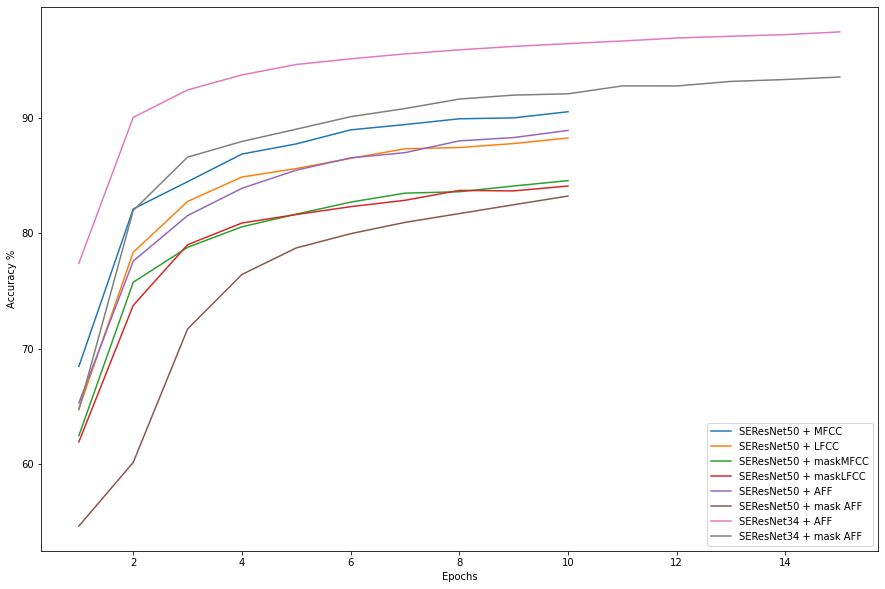

<Figure size 1080x720 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,10)

x10 = [i for i in range(1, 11)]
x15 = [i for i in range(1, 16)]
plt.plot(x10, run3, label = "SEResNet50 + MFCC")
plt.plot(x10, run4, label = "SEResNet50 + LFCC")
plt.plot(x10, run5, label = "SEResNet50 + maskMFCC")
plt.plot(x10, run6, label = "SEResNet50 + maskLFCC")
plt.plot(x10, run7, label = "SEResNet50 + AFF")
plt.plot(x10, run8, label = "SEResNet50 + mask AFF")
plt.plot(x15, run9, label = "SEResNet34 + AFF")
plt.plot(x15, run10, label = "SEResNet34 + mask AFF")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy %')
plt.show()

plt.savefig('./accVSepoch.png')